In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

In [8]:
path = "/content/drive/My Drive/AI-MINOR-JUNE/dataset/"
imagePaths = list(paths.list_images(path))
images = []
labels = []

In [9]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    images.append(image)
    labels.append(label)
images = np.array(images, dtype="float32")
labels = np.array(labels)

In [20]:
print(images.shape)
print(labels.shape)

(1376, 224, 224, 3)
(1376, 2)


In [11]:
np.unique(labels)

array(['with_mask', 'without_mask'], dtype='<U12')

In [12]:
labels = LabelBinarizer().fit_transform(labels)
labels = to_categorical(labels)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify = labels)

In [14]:
datagen = ImageDataGenerator(rotation_range = 20,
                             zoom_range = 0.15,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.15,
                             horizontal_flip = True,
                             fill_mode = "nearest")

In [16]:
baseModel = MobileNetV2(weights="imagenet", include_top = False,
                        input_tensor = Input(shape=(224, 224, 3)))
X = baseModel.output
X = AveragePooling2D(pool_size = (7, 7))(X)
X = Flatten()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(2, activation="softmax")(X)
model = Model(inputs = baseModel.input, outputs = X)

9412608/9406464 [==============================] - 0s 0us/step


In [17]:
for layer in baseModel.layers:
	layer.trainable = False

In [22]:
# model.summary()

In [23]:
batch_size = 128
epochs = 15

In [24]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch = len(X_train) // batch_size,
                 validation_data = (X_test, y_test),
                 validation_steps = len(X_test) // batch_size,
                 epochs = epochs)

Epoch 1/15
8/8 [==============================] - 45s 6s/step - loss: 0.3467 - accuracy: 0.8611 - val_loss: 0.0384 - val_accuracy: 0.9855
Epoch 2/15
8/8 [==============================] - 46s 6s/step - loss: 0.0307 - accuracy: 0.9918 - val_loss: 0.0265 - val_accuracy: 0.9891
Epoch 3/15
8/8 [==============================] - 45s 6s/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.0279 - val_accuracy: 0.9855
Epoch 4/15
8/8 [==============================] - 45s 6s/step - loss: 0.0203 - accuracy: 0.9949 - val_loss: 0.0273 - val_accuracy: 0.9855
Epoch 5/15
8/8 [==============================] - 46s 6s/step - loss: 0.0111 - accuracy: 0.9979 - val_loss: 0.0182 - val_accuracy: 0.9891
Epoch 6/15
8/8 [==============================] - 44s 6s/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0440 - val_accuracy: 0.9855
Epoch 7/15
8/8 [==============================] - 44s 6s/step - loss: 0.0066 - accuracy: 0.9969 - val_loss: 0.0328 - val_accuracy: 0.9891
Epoch 8/15
8/8 [==================

In [42]:
# encoder = LabelBinarizer()
# encoder.fit(["with_mask", "without_mask"])
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(y_test.argmax(axis=1), y_pred, 
                            target_names=LabelBinarizer().fit(["with_mask", "without_mask"]).classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.98      0.99       138
without_mask       0.98      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



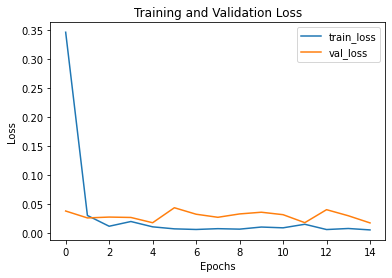

In [47]:
plt.plot(np.arange(0, epochs), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), hist.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")